# COVID-19 Forecasting using LSTM

### What are our goals?
We need to predict the number of confirmed and fatal cases of COVID-19. 
To train our model, we will take data from the past 7 days as input and predict the number of cases on the 8th day.

In [2]:
import os
import multiprocessing
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model
from keras import Input
from dateutil.relativedelta import relativedelta
from datetime import datetime
import math

In [3]:
# Computer characteristics
mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
mem_gib = mem_bytes / (1024.**3)
print("Computer characteristics: ")
print("RAM: %f GB" % mem_gib)
print("CORES: %d" % multiprocessing.cpu_count())


Computer characteristics: 
RAM: 7.653069 GB
CORES: 4


In [4]:
train = pd.read_csv("train.csv")

In [5]:
# Check null values
print("Null values(train):") 
print(train.isnull().sum())
print("\n")
countries = train['Country_Region'].unique()
print("Number of different countries: ", len(countries))
print("\n")
min_date = train.Date.min()
max_date = train.Date.max()
print("Min date: {0}\nMax date: {1}".format(min_date, max_date))

Null values(train):
Id                    0
Province_State    13376
Country_Region        0
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64


Number of different countries:  180


Min date: 2020-01-22
Max date: 2020-04-06


In [6]:
# Filling empty values
# where Province_State is null we fill it with Country_Region

def fillState(state, country):
    if state == "empty":
        return country
    return state

train['Province_State'].fillna("empty", inplace = True)
train['Province_State'] = train.loc[:,['Province_State', 'Country_Region']].apply(lambda x: fillState(x['Province_State'], x['Country_Region']), axis = 1)

train=train.rename(columns={'ConfirmedCases':'Confirmed','Fatalities':'Deaths','Country_Region':'Country/Region',
                     'Province_State':'Province/State','Date':'ObservationDate'})

num_cols=['Confirmed', 'Deaths']
# cast to int
for col in num_cols:
    temp=[int(i) for i in train[col]]
    train[col]=temp 
    
train.head()

,Id,Province/State,Country/Region,ObservationDate,Confirmed,Deaths
0,1,Afghanistan,Afghanistan,2020-01-22,0,0
1,2,Afghanistan,Afghanistan,2020-01-23,0,0
2,3,Afghanistan,Afghanistan,2020-01-24,0,0
3,4,Afghanistan,Afghanistan,2020-01-25,0,0
4,5,Afghanistan,Afghanistan,2020-01-26,0,0


In [7]:
# Creating list of all states of each country
unique_regions = train['Country/Region'].unique()
states_per_regions = list()

for reg in tqdm(unique_regions):
    states_per_regions.append(train[train['Country/Region']==reg]['Province/State'].unique()) 
    
print('Number of unique regions:', len(unique_regions))   

100%|██████████| 180/180 [00:00<00:00, 449.93it/s]

Number of unique regions: 180


In [8]:
# Creating dataset for supervised learning problem
# Basically we prepare input X - values for 7 days and output y - one value for the 8th day
# for every Country/Region and every Province/State

# target : 'Confirmed'/'Deaths'
def create_train_dataset(target, n_steps, train):
    train = train.query("ObservationDate<'2020-03-31'")
    X, y = list(), list()
    # for every Country/Region
    for k in tqdm(range(len(unique_regions))):
        # for every Province_State in the Country/Region
        for state in states_per_regions[k]:
            # take the data for every state and every country
            temp = train[(train['Country/Region'] == unique_regions[k]) &(train['Province/State'] == state)]
            # take the target data (Confirmed or Deaths) and put it in a list
            sequence = list(temp[target])
            # for the data from the list
            for i in range(len(sequence)):
                end_ix = i + n_steps
                # if we have reached the end of data - break
                if end_ix > len(sequence) - 1:
                    break
                # split into input values X and output values y
                seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
                X.append(seq_x)   
                y.append(seq_y)
                
    return np.array(X), np.array(y)      

In [9]:
# function to create test dataset
# we take the last 7 days data to predict the number of cases for 8th day

def create_test_dataset(target, n_steps, train):
    train = train.query("ObservationDate<'2020-03-31'")
    x, regs = list(), list()
    # for every Country/Region
    for k in tqdm(range(len(unique_regions))):
        # for every Province/State
        for state in states_per_regions[k]:
            temp = train[(train['Country/Region'] == unique_regions[k]) &(train['Province/State'] == state)]
            sequence = temp[target]
            # we take the last 7 days and put it in a list
            x.append(sequence[len(sequence)-n_steps:len(sequence)+1])
            # in regs we keep the (country,state) information
            regs.append((unique_regions[k],state))      
    return np.array(x), regs

In [10]:
n_steps = 7 # timestep is 7 days

# creating input and output values for confirmed cases
X_confirmed, y_confirmed = create_train_dataset('Confirmed', n_steps, train)
test_confirmed, regs = create_test_dataset('Confirmed',n_steps,train)

X_deaths, y_deaths = create_train_dataset('Deaths', n_steps, train)
test_deaths, regs = create_test_dataset('Deaths', n_steps, train)

print(test_confirmed.shape)

100%|██████████| 180/180 [00:01<00:00, 157.57it/s]

(306, 7)


### Split the data into train and test sets

In [11]:
X_train_confirmed, X_val_confirmed, y_train_confirmed, y_val_confirmed = train_test_split(X_confirmed, y_confirmed, test_size=0.30, random_state=42)
X_train_deaths, X_val_deaths, y_train_deaths, y_val_deaths = train_test_split(X_deaths, y_deaths, test_size=0.30, random_state=42)


### Reshape for LSTM

In [12]:
# Confirmed cases

X_train_confirmed = X_train_confirmed.reshape((X_train_confirmed.shape[0], 1, X_train_confirmed.shape[1]))
X_val_confirmed = X_val_confirmed.reshape(( X_val_confirmed.shape[0], 1,  X_val_confirmed.shape[1]))
X_test_c = test_confirmed.reshape(( test_confirmed.shape[0], 1, test_confirmed.shape[1]))
print(X_train_confirmed.shape, y_train_confirmed.shape, X_val_confirmed.shape, y_val_confirmed.shape, X_test_c.shape)

(13280, 1, 7) (13280,) (5692, 1, 7) (5692,) (306, 1, 7)


In [13]:
# Death cases

X_train_deaths = X_train_deaths.reshape((X_train_deaths.shape[0], 1, X_train_deaths.shape[1]))
X_val_deaths = X_val_deaths.reshape(( X_val_deaths.shape[0], 1,  X_val_deaths.shape[1]))
X_test_d = test_deaths.reshape(( test_deaths.shape[0], 1, test_deaths.shape[1]))
print(X_train_deaths.shape, y_train_deaths.shape, X_val_deaths.shape, y_val_deaths.shape, X_test_d.shape)

(13280, 1, 7) (13280,) (5692, 1, 7) (5692,) (306, 1, 7)


In [14]:
print(X_test_c[0])
print(X_test_d[0])

[[ 74  84  94 110 110 120 170]]
[[1 2 4 4 4 4 4]]


## Preparing the Model

### Model for Confirmed cases

In [15]:
# Initializing model components
epochs = 20
batch_size = 32
n_features = 1

model_c = Sequential()
# Stacked LSTM
model_c.add(LSTM(50, activation='relu', input_shape = (n_features, n_steps), return_sequences = True))
model_c.add(LSTM(150, activation='relu'))
model_c.add(Dense(1,activation='relu'))
model_c.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 50)             11600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               120600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 132,351
Trainable params: 132,351
Non-trainable params: 0
_________________________________________________________________


In [16]:
from keras.losses import MeanSquaredLogarithmicError

# Compiling the model
model_c.compile(optimizer = 'adam', loss = MeanSquaredLogarithmicError())
#callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.6),
#             EarlyStopping(monitor='val_loss', patience=20),
#             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
# fit the model
hist = model_c.fit(X_train_confirmed, y_train_confirmed, epochs = epochs, batch_size = batch_size,
                   validation_data = (X_val_confirmed, y_val_confirmed), verbose = 2, shuffle=True)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 13280 samples, validate on 5692 samples
Epoch 1/20
 - 3s - loss: 0.2053 - val_loss: 0.0411
Epoch 2/20
 - 2s - loss: 0.0447 - val_loss: 0.0394
Epoch 3/20
 - 2s - loss: 0.0437 - val_loss: 0.0398
Epoch 4/20
 - 2s - loss: 0.0434 - val_loss: 0.0393
Epoch 5/20
 - 2s - loss: 0.0431 - val_loss: 0.0397
Epoch 6/20
 - 2s - loss: 0.0431 - val_loss: 0.0393
Epoch 7/20
 - 2s - loss: 0.0427 - val_loss: 0.0392
Epoch 8/20
 - 3s - loss: 0.0428 - val_loss: 0.0393
Epoch 9/20
 - 3s - loss: 0.0427 - val_loss: 0.0393
Epoch 10/20
 - 3s - loss: 0.0427 - val_loss: 0.0394
Epoch 11/20
 - 3s - loss: 0.0427 - val_loss: 0.0401
Epoch 12/20
 - 3s - loss: 0.0427 - val_loss: 0.0405
Epoch 13/20
 - 3s - loss: 0.0427 - val_loss: 0.0392
Epoch 14/20
 - 3s - loss: 0.0426 - val_loss: 0.0402
Epoch 15/20
 - 3s - loss: 0.0426 - val_loss: 0.0397
Epoch 16/20
 - 3s - loss: 0.0426 - val_loss: 0.0391
Epoch 17/20
 - 4s - loss: 0.0427 

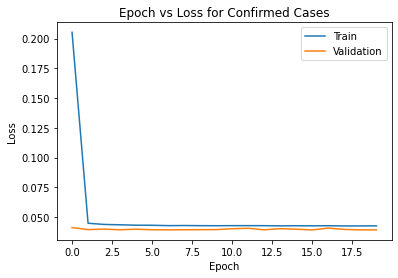

In [17]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Epoch vs Loss for Confirmed Cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

### Model for Death Cases

In [18]:
# Stadked LSTM Model
model_d = Sequential()
model_d.add(LSTM(50, activation ='relu', input_shape = (n_features, n_steps), return_sequences=True))
model_d.add(LSTM(60, activation ='relu'))
model_d.add(Dense(1))
model_d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 50)             11600     
_________________________________________________________________
lstm_4 (LSTM)                (None, 60)                26640     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 38,301
Trainable params: 38,301
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Compiling the model
model_d.compile(optimizer='adam', loss = MeanSquaredLogarithmicError())
#callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.6),
#             EarlyStopping(monitor='val_loss', patience=20),
#             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
# fit the model
hist = model_d.fit(X_train_deaths, y_train_deaths, epochs=epochs, batch_size=batch_size, 
                   validation_data=(X_val_deaths, y_val_deaths), verbose=2, shuffle=True)


Train on 13280 samples, validate on 5692 samples
Epoch 1/20
 - 3s - loss: 0.0888 - val_loss: 0.0153
Epoch 2/20
 - 2s - loss: 0.0139 - val_loss: 0.0131
Epoch 3/20
 - 2s - loss: 0.0131 - val_loss: 0.0128
Epoch 4/20
 - 2s - loss: 0.0130 - val_loss: 0.0125
Epoch 5/20
 - 2s - loss: 0.0129 - val_loss: 0.0125
Epoch 6/20
 - 2s - loss: 0.0129 - val_loss: 0.0125
Epoch 7/20
 - 2s - loss: 0.0129 - val_loss: 0.0127
Epoch 8/20
 - 2s - loss: 0.0128 - val_loss: 0.0125
Epoch 9/20
 - 2s - loss: 0.0128 - val_loss: 0.0125
Epoch 10/20
 - 2s - loss: 0.0128 - val_loss: 0.0124
Epoch 11/20
 - 2s - loss: 0.0128 - val_loss: 0.0124
Epoch 12/20
 - 2s - loss: 0.0128 - val_loss: 0.0126
Epoch 13/20
 - 2s - loss: 0.0128 - val_loss: 0.0124
Epoch 14/20
 - 2s - loss: 0.0128 - val_loss: 0.0126
Epoch 15/20
 - 2s - loss: 0.0128 - val_loss: 0.0126
Epoch 16/20
 - 2s - loss: 0.0128 - val_loss: 0.0126
Epoch 17/20
 - 2s - loss: 0.0128 - val_loss: 0.0124
Epoch 18/20
 - 2s - loss: 0.0128 - val_loss: 0.0125
Epoch 19/20
 - 2s - loss

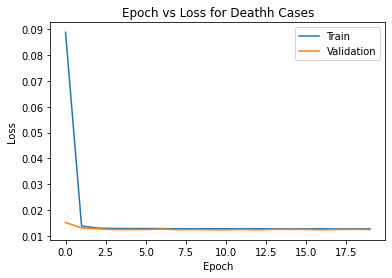

In [20]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Epoch vs Loss for Deathh Cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

## Utilities for Prediction and Submission

In [21]:
import math
def predict(model, data):
    y_pred = model.predict(data)
    # cast to int - we can't have non-integer values 
    y_pred = [math.ceil(i) for i in y_pred]
    return y_pred

In [23]:
# Utility method for Forecasting
import datetime
# model - trained model on Confirmed/Deaths data
# start_date - Starting date of forecasting
# num_days - Number of days for which forcasting is required
# data - the last 7 days of confirmed or death cases

def forecast(model, data, start_date, num_days):
    # we store result in a map
    res_ = dict()
    for i in range(len(data)):
        # key is index of the data - i
        res_[i] = []

    y_pred = predict(model, data)
    # list of dates to be predicted
    dates = []
    # cast string from function call to date 
    date1 = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    # creating a forecast for the next num_days days
    for j in range(1, num_days + 1): # j = 1..num_days
        for i in range(len(data)): 
            cur_window = list(data[i][0][1:n_steps+1])
            #print(j, i, cur_window[-1])
            res_[i].append(cur_window[-1])
            # adding predicted value for 8th day
            cur_window.append(y_pred[i])
            
            data[i][0] = cur_window
        
        # predict for the next day (j)
        y_pred = predict(model,data)
        # add date to a list
        dates.append(date1.strftime("%Y-%m-%d"))
        # increment date
        date1 += relativedelta(days = 1)
       
    # make a dataframe of predictions
    res = pd.DataFrame(pd.DataFrame(pd.DataFrame(res_).values.T)) 
    res.columns = dates
    #print(res.head())
    res['Country/State'] = regs
    return res
    
    
# num_days = Num of days for which forecasting is required
res_confirmed = forecast(model_c, X_test_c, '2020-04-5', num_days = 30)
res_confirmed[res_confirmed['Country/State'] == ('Serbia', 'Serbia')]

#res_deaths = forecast(model_d, X_test_d, '2020-03-31', num_days = 30)

,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,...,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,Country/State
209,785,943,1091,1260,1460,1686,1948,2254,2604,3009,...,16808,19381,22346,25762,29698,34233,39458,45477,52412,"(Serbia, Serbia)"
